# 人机交互

在工作流中，你可以介入任意节点来进行审查等操作
- 批准或拒绝
- 编辑图表状态
- 审查工具调用
- 验证人类输入

In [32]:
! pip install langgraph langchain_core


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


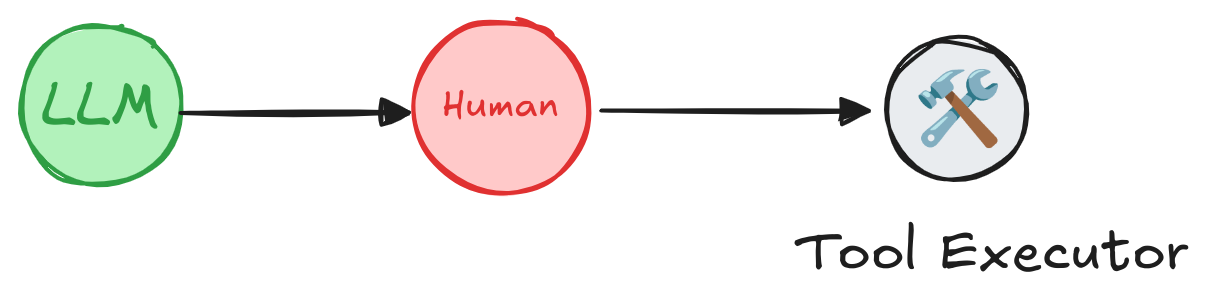

## interrupt暂停图

interrupt 函数执行的时候会暂停整个图的运行

通过Command可以恢复整个图的运行

In [33]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph

from langgraph.types import interrupt, Command


class State(TypedDict):
    some_text: str


def human_node(state: State):
    value = interrupt(  
        {
            "text_to_revise": state["some_text"]  
        }
    )
    return {
        "some_text": value  
    }


# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")
checkpointer = InMemorySaver()  
graph = graph_builder.compile(checkpointer=checkpointer)

# Pass a thread ID to the graph to run it.
config = {"configurable": {"thread_id": uuid.uuid4()}}
# Run the graph until the interrupt is hit.
result = graph.invoke({"some_text": "original text"}, config=config)  

print(result['__interrupt__']) 
# > [
# >    Interrupt(
# >       value={'text_to_revise': 'original text'},
# >       resumable=True,
# >       ns=['human_node:6ce9e64f-edef-fe5d-f7dc-511fa9526960']
# >    )
# > ]
print(result["__interrupt__"])  
# > [Interrupt(value={'text_to_revise': 'original text'}, id='6d7c4048049254c83195429a3659661d')]

print(graph.invoke(Command(resume="Edited text"), config=config)) 
# > {'some_text': 'Edited text'}

[Interrupt(value={'text_to_revise': 'original text'}, id='b07d373c44a01dac5c9bece8cf671dfd')]
[Interrupt(value={'text_to_revise': 'original text'}, id='b07d373c44a01dac5c9bece8cf671dfd')]
{'some_text': 'Edited text'}


## 审批操作

增加一个human_approval节点，在节点暂停的时候，接受用户的处理值，通过command恢复图执行并更新值

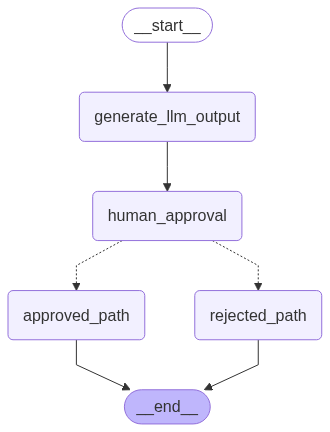

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='b07d1fc79f2ceb50f29043a7fc91fc64')]
✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


In [34]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])
# Output:
# Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, ...)

# 人工恢复节点，通过, 并且human_approval更新了decision的值
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

## 在节点中修改值

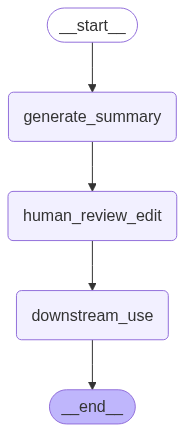

[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, id='dd095803f3ae8ce25193ce25e14ad055')]
✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


In [35]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))
# Invoke the graph until it hits the interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# Output interrupt payload
print(result["__interrupt__"])


# 在这里恢复图状态并传递修改的值
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)

## 审查工具调用

作为工具的确认环节来调用

OPENAI_API_KEY sk-ergndkhlwwhopjyicyysufmfkvbmjxmdcvwlbxvnoloduita https://api.siliconflow.cn/v1 moonshotai/Kimi-K2-Instruct


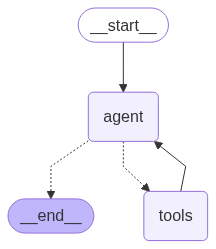

In [36]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

llm = ChatOpenAI(
  api_key=os.getenv('OPENAI_API_KEY'),
  base_url=os.getenv('OPENAI_BASE_URL'),
  model=os.getenv('MODEL_NAME'),
)

print('OPENAI_API_KEY', os.getenv('OPENAI_API_KEY'), os.getenv('OPENAI_BASE_URL'), os.getenv('MODEL_NAME'))

agent_executor = create_react_agent(
    model=llm,
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

### 调用时候暂停
等待确认

In [37]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent_executor.stream(
    {"messages": [{"role": "user", "content": "请你帮我预订一个亚朵酒店"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='我来帮您预订亚朵酒店。', additional_kwargs={'tool_calls': [{'id': 'functions.book_hotel:0', 'function': {'arguments': '{"hotel_name": "亚朵酒店"}', 'name': 'book_hotel'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 99, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_name': 'moonshotai/Kimi-K2-Instruct', 'system_fingerprint': '', 'id': '0198ac749ce97c43495524631e045586', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e8688090-5814-4c5f-804f-4f368a120a53-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': '亚朵酒店'}, 'id': 'functions.book_hotel:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'output_tokens': 27, 'total_tokens': 126, 'input_token_details': {}, 'output_token_det

### 确认工具调用

In [38]:
from langgraph.types import Command

for chunk in agent_executor.stream(
    Command(resume={"type": "accept"}),  
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at 亚朵酒店.', name='book_hotel', id='5975763b-e520-4505-adf5-cb86583a7cc3', tool_call_id='functions.book_hotel:0')]}}


{'agent': {'messages': [AIMessage(content='已成功为您预订亚朵酒店。祝您的旅程愉快！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 155, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_name': 'moonshotai/Kimi-K2-Instruct', 'system_fingerprint': '', 'id': '0198ac7654a8f047e146d5fbcab6efa4', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--8e7de3c2-f799-4f67-aabf-7bb0142cb29e-0', usage_metadata={'input_tokens': 155, 'output_tokens': 12, 'total_tokens': 167, 'input_token_details': {}, 'output_token_details': {'reasoning': 0}})]}}


